In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from models_.lvmogp_svi import LVMOGP_SVI
from models_.gaussian_likelihood import GaussianLikelihood
from models_.variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *
import yaml
import time

## Experi random seed

In [2]:
expri_random_seed = 67 # 18 # 198

## Read in and joint different piece of trails as different outputs (with truncation length 200)... 

In [3]:
# Subject 08

synth_data_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/CMU_motion_capture'
w_C_08_02 = Tensor(pd.read_csv(f'{synth_data_path}/08_02.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_08_03 = Tensor(pd.read_csv(f'{synth_data_path}/08_03.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_08_08 = Tensor(pd.read_csv(f'{synth_data_path}/08_08.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_08_09 = Tensor(pd.read_csv(f'{synth_data_path}/08_09.csv').to_numpy()).reshape(-1).reshape(62, -1)

print('w_C_08_02 has shape', w_C_08_02.shape)
print('w_C_08_03 has shape', w_C_08_03.shape)
print('w_C_08_08 has shape', w_C_08_08.shape)
print('w_C_08_09 has shape', w_C_08_09.shape)

w_C_08_02_ = w_C_08_02[:, 55:255]
w_C_08_03_ = w_C_08_03[:, 77:277]
w_C_08_08_ = w_C_08_08[:, 42:242]
w_C_08_09_ = w_C_08_09[:, 47:247]

assert w_C_08_09_.shape == w_C_08_08_.shape == w_C_08_03_.shape == w_C_08_02_.shape == torch.Size([62, 200])


w_C_08_02 has shape torch.Size([62, 309])
w_C_08_03 has shape torch.Size([62, 353])
w_C_08_08 has shape torch.Size([62, 283])
w_C_08_09 has shape torch.Size([62, 293])


In [ ]:
# Subject 09
'''
synth_data_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/CMU_motion_capture'
w_C_09_01 = Tensor(pd.read_csv(f'{synth_data_path}/09_01.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_09_02 = Tensor(pd.read_csv(f'{synth_data_path}/09_02.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_09_03 = Tensor(pd.read_csv(f'{synth_data_path}/09_03.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_09_05 = Tensor(pd.read_csv(f'{synth_data_path}/09_05.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_09_06 = Tensor(pd.read_csv(f'{synth_data_path}/09_06.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_09_11 = Tensor(pd.read_csv(f'{synth_data_path}/09_11.csv').to_numpy()).reshape(-1).reshape(62, -1)

print('w_C_09_01 has shape', w_C_09_01.shape)
print('w_C_09_02 has shape', w_C_09_02.shape)
print('w_C_09_03 has shape', w_C_09_03.shape)
print('w_C_09_05 has shape', w_C_09_05.shape)
print('w_C_09_06 has shape', w_C_09_06.shape)
print('w_C_09_11 has shape', w_C_09_11.shape)

w_C_09_01_ = w_C_09_01[:, 24:124]
w_C_09_02_ = w_C_09_02[:, 15:115]
w_C_09_03_ = w_C_09_03[:, 14:114]
w_C_09_05_ = w_C_09_05[:, 22:122]
w_C_09_06_ = w_C_09_06[:, 21:121]
w_C_09_11_ = w_C_09_11[:, 33:133]

assert w_C_09_01_.shape == w_C_09_02_.shape == w_C_09_03_.shape == w_C_09_05_.shape == w_C_09_06_.shape == w_C_09_11_.shape == torch.Size([62, 100])
'''

In [ ]:
# Subject 64
'''
synth_data_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/CMU_motion_capture'
w_C_64_03 = Tensor(pd.read_csv(f'{synth_data_path}/64_03.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_64_04 = Tensor(pd.read_csv(f'{synth_data_path}/64_04.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_64_05 = Tensor(pd.read_csv(f'{synth_data_path}/64_05.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_64_07 = Tensor(pd.read_csv(f'{synth_data_path}/64_07.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_64_08 = Tensor(pd.read_csv(f'{synth_data_path}/64_08.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_64_09 = Tensor(pd.read_csv(f'{synth_data_path}/64_09.csv').to_numpy()).reshape(-1).reshape(62, -1)

print('w_C_64_03 has shape', w_C_64_03.shape)
print('w_C_64_04 has shape', w_C_64_04.shape)
print('w_C_64_05 has shape', w_C_64_05.shape)
print('w_C_64_07 has shape', w_C_64_07.shape)
print('w_C_64_08 has shape', w_C_64_08.shape)
print('w_C_64_09 has shape', w_C_64_09.shape)

w_C_64_03_ = w_C_64_03[:, 72:372]
w_C_64_04_ = w_C_64_04[:, 56:356]
w_C_64_05_ = w_C_64_05[:, 44:344]
w_C_64_07_ = w_C_64_07[:, 38:338]
w_C_64_08_ = w_C_64_08[:, 32:332]
w_C_64_09_ = w_C_64_09[:, 76:376]

assert w_C_64_03_.shape == w_C_64_04_.shape == w_C_64_05_.shape == w_C_64_07_.shape == w_C_64_08_.shape == w_C_64_09_.shape == torch.Size([62, 300])
'''

In [ ]:
# Subject 118
'''
synth_data_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/CMU_motion_capture'
w_C_118_03 = Tensor(pd.read_csv(f'{synth_data_path}/118_03.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_118_04 = Tensor(pd.read_csv(f'{synth_data_path}/118_04.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_118_11 = Tensor(pd.read_csv(f'{synth_data_path}/118_11.csv').to_numpy()).reshape(-1).reshape(62, -1)
w_C_118_17 = Tensor(pd.read_csv(f'{synth_data_path}/118_17.csv').to_numpy()).reshape(-1).reshape(62, -1)

print('w_C_118_03 has shape', w_C_118_03.shape)
print('w_C_118_04 has shape', w_C_118_04.shape)
print('w_C_118_11 has shape', w_C_118_11.shape)
print('w_C_118_17 has shape', w_C_118_17.shape)

w_C_118_03_ = w_C_118_03[:, 49:449]
w_C_118_04_ = w_C_118_04[:, 123:523]
w_C_118_11_ = w_C_118_11[:, 146:546]
w_C_118_17_ = w_C_118_17[:, 123:523]
'''

## filter out noisy outputs (low signal-to-noise ratio)

In [4]:
# Subject 08

snr_list_08_02, snr_index_08_02 = compute_signal_to_noise_ratio(w_C_08_02_)
snr_list_08_03, snr_index_08_03 = compute_signal_to_noise_ratio(w_C_08_03_)
snr_list_08_08, snr_index_08_08 = compute_signal_to_noise_ratio(w_C_08_08_)
snr_list_08_09, snr_index_08_09 = compute_signal_to_noise_ratio(w_C_08_09_)

inf_indices_08_02 = [index for index, value in enumerate(snr_list_08_02) if value == float('inf')]
inf_indices_08_03 = [index for index, value in enumerate(snr_list_08_03) if value == float('inf')]
inf_indices_08_08 = [index for index, value in enumerate(snr_list_08_08) if value == float('inf')]
inf_indices_08_09 = [index for index, value in enumerate(snr_list_08_09) if value == float('inf')]
inf_to_exclude = list(set(inf_indices_08_02) & set(inf_indices_08_03) & set(inf_indices_08_08) & set(inf_indices_08_09))

common_idxs_list_ = list(set(snr_index_08_02[:30]) & set(snr_index_08_03[:30]) & set(snr_index_08_08[:30]) & set(snr_index_08_09[:30]))
common_idxs_list = list(set(common_idxs_list_) - set(inf_to_exclude))
print(len(common_idxs_list))

w_C_08_02_ = w_C_08_02_[common_idxs_list,:]
w_C_08_03_ = w_C_08_03_[common_idxs_list,:]
w_C_08_08_ = w_C_08_08_[common_idxs_list,:]
w_C_08_09_ = w_C_08_09_[common_idxs_list,:]


19


In [ ]:
# Subject 09
'''
snr_list_09_01, snr_index_09_01 = compute_signal_to_noise_ratio(w_C_09_01_)
snr_list_09_02, snr_index_09_02 = compute_signal_to_noise_ratio(w_C_09_02_)
snr_list_09_03, snr_index_09_03 = compute_signal_to_noise_ratio(w_C_09_03_)
snr_list_09_05, snr_index_09_05 = compute_signal_to_noise_ratio(w_C_09_05_)
snr_list_09_06, snr_index_09_06 = compute_signal_to_noise_ratio(w_C_09_06_)
snr_list_09_11, snr_index_09_11 = compute_signal_to_noise_ratio(w_C_09_11_)

inf_indices_09_01 = [index for index, value in enumerate(snr_list_09_01) if value == float('inf')]
inf_indices_09_02 = [index for index, value in enumerate(snr_list_09_02) if value == float('inf')]
inf_indices_09_03 = [index for index, value in enumerate(snr_list_09_03) if value == float('inf')]
inf_indices_09_05 = [index for index, value in enumerate(snr_list_09_05) if value == float('inf')]
inf_indices_09_06 = [index for index, value in enumerate(snr_list_09_06) if value == float('inf')]
inf_indices_09_11 = [index for index, value in enumerate(snr_list_09_11) if value == float('inf')]
inf_to_exclude = list(set(inf_indices_09_01) & set(inf_indices_09_02) & set(inf_indices_09_03) & set(inf_indices_09_05) & set(inf_indices_09_06) & set(inf_indices_09_11))

common_idxs_list_ = list(set(snr_index_09_01[:30]) & set(snr_index_09_02[:30]) & set(snr_index_09_03[:30]) & set(snr_index_09_05[:30]) & set(snr_index_09_06[:30]) & set(snr_index_09_11[:30]))
common_idxs_list = list(set(common_idxs_list_) - set(inf_to_exclude))
print(len(common_idxs_list))

w_C_09_01_ = w_C_09_01_[common_idxs_list,:]
w_C_09_02_ = w_C_09_02_[common_idxs_list,:]
w_C_09_03_ = w_C_09_03_[common_idxs_list,:]
w_C_09_05_ = w_C_09_05_[common_idxs_list,:]
w_C_09_06_ = w_C_09_06_[common_idxs_list,:]
w_C_09_11_ = w_C_09_11_[common_idxs_list,:]
'''

In [ ]:
# Subject 64
'''
snr_list_64_03, snr_index_64_03 = compute_signal_to_noise_ratio(w_C_64_03_)
snr_list_64_04, snr_index_64_04 = compute_signal_to_noise_ratio(w_C_64_04_)
snr_list_64_05, snr_index_64_05 = compute_signal_to_noise_ratio(w_C_64_05_)
snr_list_64_07, snr_index_64_07 = compute_signal_to_noise_ratio(w_C_64_07_)
snr_list_64_08, snr_index_64_08 = compute_signal_to_noise_ratio(w_C_64_08_)
snr_list_64_09, snr_index_64_09 = compute_signal_to_noise_ratio(w_C_64_09_)

inf_indices_64_03 = [index for index, value in enumerate(snr_list_64_03) if value == float('inf')]
inf_indices_64_04 = [index for index, value in enumerate(snr_list_64_04) if value == float('inf')]
inf_indices_64_05 = [index for index, value in enumerate(snr_list_64_05) if value == float('inf')]
inf_indices_64_07 = [index for index, value in enumerate(snr_list_64_07) if value == float('inf')]
inf_indices_64_08 = [index for index, value in enumerate(snr_list_64_08) if value == float('inf')]
inf_indices_64_09 = [index for index, value in enumerate(snr_list_64_09) if value == float('inf')]
inf_to_exclude = list(set(inf_indices_64_03) & set(inf_indices_64_04) & set(inf_indices_64_05) & set(inf_indices_64_07) & set(inf_indices_64_08) & set(inf_indices_64_09))

common_idxs_list_ = list(set(snr_index_64_03[:30]) & set(snr_index_64_04[:30]) & set(snr_index_64_05[:30]) & set(snr_index_64_07[:30]) & set(snr_index_64_08[:30]) & set(snr_index_64_09[:30]))
common_idxs_list = list(set(common_idxs_list_) - set(inf_to_exclude))
print(len(common_idxs_list))

w_C_64_03_ = w_C_64_03_[common_idxs_list,:]
w_C_64_04_ = w_C_64_04_[common_idxs_list,:]
w_C_64_05_ = w_C_64_05_[common_idxs_list,:]
w_C_64_07_ = w_C_64_07_[common_idxs_list,:]
w_C_64_08_ = w_C_64_08_[common_idxs_list,:]
w_C_64_09_ = w_C_64_09_[common_idxs_list,:]
'''

In [ ]:
# Subject 118
'''
snr_list_118_03, snr_index_118_03 = compute_signal_to_noise_ratio(w_C_118_03_)
snr_list_118_04, snr_index_118_04 = compute_signal_to_noise_ratio(w_C_118_04_)
snr_list_118_11, snr_index_118_11 = compute_signal_to_noise_ratio(w_C_118_11_)
snr_list_118_17, snr_index_118_17 = compute_signal_to_noise_ratio(w_C_118_17_)

inf_indices_118_03 = [index for index, value in enumerate(snr_list_118_03) if value == float('inf')]
inf_indices_118_04 = [index for index, value in enumerate(snr_list_118_04) if value == float('inf')]
inf_indices_118_11 = [index for index, value in enumerate(snr_list_118_11) if value == float('inf')]
inf_indices_118_17 = [index for index, value in enumerate(snr_list_118_17) if value == float('inf')]
inf_to_exclude = list(set(inf_indices_118_03) & set(inf_indices_118_04) & set(inf_indices_118_11) & set(inf_indices_118_17))

common_idxs_list_ = list(set(snr_index_118_03[:30]) & set(snr_index_118_04[:30]) & set(snr_index_118_11[:30]) & set(snr_index_118_17[:30]))
common_idxs_list = list(set(common_idxs_list_) - set(inf_to_exclude))
print(len(common_idxs_list))

w_C_118_03_ = w_C_118_03_[common_idxs_list,:]
w_C_118_04_ = w_C_118_04_[common_idxs_list,:]
w_C_118_11_ = w_C_118_11_[common_idxs_list,:]
w_C_118_17_ = w_C_118_17_[common_idxs_list,:]
'''

In [ ]:
# sprint('How many outputs have SNR over 5? ', (np.array(snr_list_08_09) > 10).sum())

In [ ]:
# plt.plot(w_C_64_03_[0])

## Cat different trails

In [5]:
# Modify following line to get different number of trails ... 
# w_sample_total_data = torch.cat((w_C_08_02_), dim=0)
# w_sample_total_data = torch.cat((w_C_09_01_, w_C_09_02_, w_C_09_03_, w_C_09_05_, w_C_09_06_, w_C_09_11_), dim=0)
w_sample_total_data = w_C_08_02_
w_sample_total_data = w_sample_total_data.reshape(-1)
# print(w_sample_total_data.shape)

In [6]:
# print(w_C_total)
w_n_C_total = 200
w_C_total = Tensor( (np.arange(w_n_C_total)/w_n_C_total) * 20 - 10)
w_n_outputs = int(19 * 1)
assert w_sample_total_data.shape[0] == int(w_n_outputs * w_n_C_total)

### train/test split for every output

In [7]:
w_n_C_train = 100 # the number of training data points per output
w_n_C_test = w_n_C_total - w_n_C_train

np.random.seed(expri_random_seed)
list_expri_random_seeds = np.random.randn(w_n_outputs)

# different from the previous case, C_train and C_test no longer a single set, but every output has different values.
w_ls_of_ls_train_C = [] # idx of C, of length w_n_outputs, every element is a list of length w_n_C_train.
w_ls_of_ls_test_C = []  # idx of C, of length w_n_outputs, every element is a list of length w_n_C_test.

w_sample_train_index, w_sample_test_index = [], []

for i in range(w_n_outputs):
    # iterate across different output functions
    random.seed(list_expri_random_seeds[i])
    train_index = random.sample(range(w_n_C_total), w_n_C_train)
    test_index = [index for index in range(w_n_C_total) if index not in train_index]
    w_ls_of_ls_train_C.append(train_index)
    w_ls_of_ls_test_C.append(test_index)
    
    w_sample_train_index = np.concatenate((w_sample_train_index, list(np.array(train_index) + w_n_C_total*i)))
    w_sample_test_index = np.concatenate((w_sample_test_index, list(np.array(test_index) + w_n_C_total*i)))

### record mean and std for train data of every output

In [8]:
w_list_of_train_C_mean = []
w_list_of_train_C_std = []

w_sample_total_data_ = w_sample_total_data.reshape(w_n_outputs, w_n_C_total)
for i in range(w_n_outputs):
    i_th_output_traindata = w_sample_total_data_[i][w_ls_of_ls_train_C[i]]
    w_list_of_train_C_mean.append(float(i_th_output_traindata.mean()))
    w_list_of_train_C_std.append(float(i_th_output_traindata.std()))

assert len(w_list_of_train_C_mean) == len(w_list_of_train_C_std) == w_n_outputs

In [9]:
w_sample_total_data = torch.zeros(w_n_outputs, w_n_C_total)
for i in range(w_n_outputs):
    w_sample_total_data[i] = ( w_sample_total_data_[i] - w_list_of_train_C_mean[i] ) / w_list_of_train_C_std[i]

w_sample_total_data = w_sample_total_data.reshape(-1)

print('final total_data of shape', w_sample_total_data.shape)
w_sample_train_data = w_sample_total_data[w_sample_train_index]
w_sample_test_data = w_sample_total_data[w_sample_test_index]

assert w_sample_train_data.shape[0] == w_n_C_train * w_n_outputs
assert w_sample_test_data.shape[0] == w_n_C_test * w_n_outputs

final total_data of shape torch.Size([3800])


In [ ]:
# make sure no nan number here!
# print(w_sample_test_data.max())

## Define model and Training

In [10]:
# define hyper-parameters
w_n_X = w_n_outputs
w_n_C = len(w_ls_of_ls_train_C[0])
w_n_total = w_n_X * w_n_C
w_index_dim = 1
w_latent_dim = 5
w_n_inducing_C = 30
w_n_inducing_X = 50
w_pca = False
# NOTE
learn_inducing_locations_X = True # False
learn_inducing_locations_C = True # True

Y_train = w_sample_train_data

# specify model
w_my_model = LVMOGP_SVI(w_n_X, w_n_C, w_index_dim, w_latent_dim, w_n_inducing_C, w_n_inducing_X, Y_train.reshape(w_n_X, -1), pca=w_pca, learn_inducing_locations_X=learn_inducing_locations_X, learn_inducing_locations_C=learn_inducing_locations_C)

# Likelihood & training objective
w_likelihood = GaussianLikelihood()
w_mll = VariationalELBO(w_likelihood, w_my_model, num_data=w_n_total)

# optimizer and scheduler
w_optimizer = torch.optim.Adam([
    {'params': w_my_model.parameters()},
    {'params': w_likelihood.parameters()}
], lr=0.01)

w_scheduler = StepLR(w_optimizer, step_size=50, gamma=0.95)  # every 50 iterations, learning rate multiple 0.95

# Initialize inducing points in C space
# Approach 1: random initialization
# w_my_model.variational_strategy.inducing_points_C.data = torch.rand(w_n_inducing_C).reshape(-1,1) * 20 - 10
# Approach 2: evenly spaced initialization
w_my_model.variational_strategy.inducing_points_C.data = Tensor(np.linspace(-10, 10, w_n_inducing_C).reshape(-1, 1))

# Initialize likelihood noise as true value
w_likelihood.noise = Tensor([0.05])

# start training!
w_loss_list = []
w_grads_list = []
w_param_value_list = []
n_iterations = 2500 # 10000
iterator = trange(n_iterations, leave=True)
batch_size_X = 17 # mini-batch for latents
batch_size_C = 50 # mini-batch for inputs, one can set w_n_C_train
num_X_MC = 10 # the number of MC samples used to approximate E_{q(X)}
w_model_max_grad_norm = 1 # 1
w_likeli_max_grad_norm = 0.1 # 0.1

w_my_model.train()
w_likelihood.train()
start_time = time.time()
for i in iterator: 
    batch_index_X, batch_index_C = sample_index_X_and_C_from_list(w_ls_of_ls_train_C, batch_size_X=batch_size_X, batch_size_C=batch_size_C)
    # core code is here 
    w_optimizer.zero_grad()

    loss_value = 0.0
    for _ in range(num_X_MC):
        sample_batch_X = w_my_model.sample_latent_variable(batch_index_X)
        sample_batch_C = w_C_total[batch_index_C]
        output_batch = w_my_model(sample_batch_X, sample_batch_C) # q(f)
        batch_index_Y = inhomogeneous_index_of_batch_Y(batch_index_X, batch_index_C, w_n_X, w_n_C_total)
        # print('batch_index_Y', len(batch_index_Y))
        loss = -w_mll(output_batch, w_sample_total_data[batch_index_Y]).sum()
        loss_value += loss.item()
        loss.backward()
    loss_value /= num_X_MC
    dict_grads, dict_param_values = collect_model_gradients(w_my_model)
    w_loss_list.append(loss_value)
    w_grads_list.append(dict_grads)
    w_param_value_list.append(dict_param_values)
    iterator.set_description('Loss: ' + str(float(np.round(loss_value, 3))) + ", iter no: " + str(i))
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(w_my_model.parameters(), w_model_max_grad_norm)
    torch.nn.utils.clip_grad_norm_(w_likelihood.parameters(), w_likeli_max_grad_norm)

    w_optimizer.step()
    w_scheduler.step()

end_time = time.time()
print('Total Training Time:',  end_time - start_time)

Loss: 0.044, iter no: 2499: 100%|██████████| 2500/2500 [2:05:45<00:00,  3.02s/it]     

Total Training Time: 7545.484986066818


In [11]:
# remove abnormal values (happens when non psd matrix cholesky occur)
w_loss_list = list(np.array(w_loss_list)[np.array(w_loss_list) < 3])

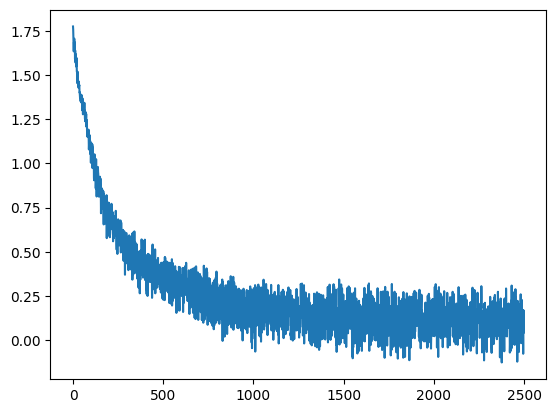

In [12]:
import matplotlib.pyplot as plt
plt.plot(w_loss_list)
train_loss_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/syn_data_training_loss_numofoutput_{w_n_outputs}.png'
plt.savefig(train_loss_path)

## Testing

In [13]:
# prediction output for grid (total) inputs.
w_my_model.eval()
w_likelihood.eval()

all_index_X = np.array([[i]*w_n_C_total for i in range(w_n_outputs)]).reshape(-1).tolist() 
all_index_C = [i for i in range(w_n_C_total)] * w_n_outputs 
len_X = len(all_index_X)
assert len_X == len(all_index_C)
all_mean_X = w_my_model.X.q_mu

test_mini_batch_size = 1000

all_pred_mean = torch.zeros(len_X)
all_pred_var = torch.zeros(len_X)
test_continue = True
test_start_idx = 0
test_end_idx = test_mini_batch_size

while test_continue:
    batch_X = all_mean_X[all_index_X[test_start_idx:test_end_idx]]
    batch_C = w_C_total[all_index_C[test_start_idx:test_end_idx]]
    batch_output = w_likelihood(w_my_model(batch_X, batch_C))
    all_pred_mean[test_start_idx:test_end_idx] = batch_output.loc.detach()
    all_pred_var[test_start_idx:test_end_idx] = batch_output.variance.detach()

    if test_end_idx < len_X:
        test_start_idx += test_mini_batch_size
        test_end_idx += test_mini_batch_size
        test_end_idx = min(test_end_idx, len_X)
    else:
        test_continue = False

In [14]:
# finer grid for better visualization ... nothing to do with RMSE computation ... 

n_data4visual = 500
w_C_total4visual = Tensor(np.linspace(-10, 10, n_data4visual))
all_index_X4visual = np.array([[i]*n_data4visual for i in range(w_n_outputs)]).reshape(-1).tolist() 
all_index_C4visual = [i for i in range(n_data4visual)] * w_n_outputs 

len_X4visual = len(all_index_X4visual)
assert len_X4visual == len(all_index_C4visual)

test_mini_batch_size = 3000

all_pred_mean4visual = torch.zeros(len_X4visual)
all_pred_var4visual = torch.zeros(len_X4visual)

test_continue = True
test_start_idx = 0
test_end_idx = test_mini_batch_size

while test_continue:
    batch_X = all_mean_X[all_index_X4visual[test_start_idx:test_end_idx]]
    batch_C = w_C_total4visual[all_index_C4visual[test_start_idx:test_end_idx]]
    batch_output = w_likelihood(w_my_model(batch_X, batch_C))
    all_pred_mean4visual[test_start_idx:test_end_idx] = batch_output.loc.detach()
    all_pred_var4visual[test_start_idx:test_end_idx] = batch_output.variance.detach()

    if test_end_idx < len_X4visual:
        test_start_idx += test_mini_batch_size
        test_end_idx += test_mini_batch_size
        test_end_idx = min(test_end_idx, len_X4visual)
    else:
        test_continue = False

## Train/Test data RMSE

In [15]:
w_train_data_predict = all_pred_mean[w_sample_train_index]
train_rmse = (w_train_data_predict - w_sample_train_data).square().mean().sqrt()
print('Global Train RMSE', train_rmse)

w_test_data_predict = all_pred_mean[w_sample_test_index]
test_rmse = (w_test_data_predict - w_sample_test_data).square().mean().sqrt()
print('Global Test RMSE', test_rmse)

Global Train RMSE tensor(0.4013)
Global Test RMSE tensor(0.4834)


## Train/Test data NLL

In [16]:
train_nll = neg_log_likelihood(Target=w_sample_train_data, GaussianMean=all_pred_mean[w_sample_train_index], GaussianVar=all_pred_var[w_sample_train_index])
test_nll = neg_log_likelihood(Target=w_sample_test_data, GaussianMean=all_pred_mean[w_sample_test_index], GaussianVar=all_pred_var[w_sample_test_index])

print('Global Train negative log likelihood:', train_nll)
print('Global Test negative log likelihood', test_nll)

Global Train negative log likelihood: tensor(-0.2849)
Global Test negative log likelihood tensor(0.1749)


## Visual Inspect

In [17]:
def evaluate_on_simgle_output(w_function_index):
    # Pick the index of the funtion to show
    # w_function_index = 982 # 

    performance_dirct = {}
    w_train_input = w_C_total[w_ls_of_ls_train_C[w_function_index]]
    w_train_start = 0
    for i in range(w_function_index):
        w_train_start += len(w_ls_of_ls_train_C[i]) # don't assume every output has the same length of inputs
    w_train_end = w_train_start + len(w_ls_of_ls_train_C[w_function_index])
    w_train_target = w_sample_train_data[w_train_start:w_train_end]
    w_train_predict = w_train_data_predict[w_train_start:w_train_end]
    train_rmse_ = (w_train_target - w_train_predict).square().mean().sqrt()
    train_nll_ = neg_log_likelihood(w_train_target, all_pred_mean[w_sample_train_index][w_train_start:w_train_end], all_pred_var[w_sample_train_index][w_train_start:w_train_end])
    # print('train rmse', train_rmse_)
    # print('train nll:', train_nll_)
    performance_dirct['train_rmse'] = train_rmse_
    performance_dirct['train_nll'] = train_nll_

    w_test_input = w_C_total[w_ls_of_ls_test_C[w_function_index]]
    w_test_start = 0
    for j in range(w_function_index):
        w_test_start += len(w_ls_of_ls_test_C[i])
    w_test_end = w_test_start + len(w_ls_of_ls_test_C[w_function_index])
    w_test_target = w_sample_test_data[w_test_start:w_test_end]
    w_test_predict = w_test_data_predict[w_test_start:w_test_end]
    test_rmse_ = (w_test_predict - w_test_target).square().mean().sqrt()
    test_nll_ = neg_log_likelihood(w_test_target, all_pred_mean[w_sample_test_index][w_test_start:w_test_end], all_pred_var[w_sample_test_index][w_test_start:w_test_end])
    # print('test rmse', test_rmse_)
    # print('test nll', test_nll_)
    performance_dirct['test_rmse'] = test_rmse_
    performance_dirct['test_nll'] = test_nll_

    w_gp_input = w_C_total
    w_gp_start = w_gp_input.shape[0] * w_function_index
    w_gp_end = w_gp_start + w_gp_input.shape[0]
    w_gp_target = w_sample_total_data[w_gp_start:w_gp_end]

    # NOTE: comment these since bad visualization ... 
    # w_gp_pred_mean = all_pred_mean[w_gp_start:w_gp_end]
    # w_gp_pred_std = all_pred_var[w_gp_start:w_gp_end]

    w_gp4visual_start = n_data4visual * w_function_index
    w_gp4visual_end = n_data4visual * (w_function_index + 1)
    w_gp_pred_mean = all_pred_mean4visual[w_gp4visual_start:w_gp4visual_end]
    w_gp_pred_std = all_pred_var4visual.sqrt()[w_gp4visual_start:w_gp4visual_end]

    return w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct
    

## loop over all function index

In [18]:
train_rmse_list = [] # list of tensors
test_rmse_list = []
train_nll_list = []
test_nll_list = []
for output_index in range(w_n_outputs):
    _, _, _, _, _, _, performance_dirct = evaluate_on_simgle_output(output_index)
    train_rmse_list.append(performance_dirct['train_rmse'])
    test_rmse_list.append(performance_dirct['test_rmse'])
    train_nll_list.append(performance_dirct['train_nll'])
    test_nll_list.append(performance_dirct['test_nll'])

In [19]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [20]:
print('The output index with WORSE test rmse performance: ', test_rmse_list.index(max(test_rmse_list)))
print('The output index with WORSE test nll performance: ', test_nll_list.index(max(test_nll_list)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list.index(min(test_rmse_list)))
print('The output index with BEST test nll performance: ', test_nll_list.index(min(test_nll_list)))

The output index with WORSE test rmse performance:  5
The output index with WORSE test nll performance:  5
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 15
The output index with MIDDLE test nll performance: 15
------------------------------------------------------------
The output index with BEST test rmse performance:  17
The output index with BEST test nll performance:  17


In [21]:
function_index = 5
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_simgle_output(function_index)

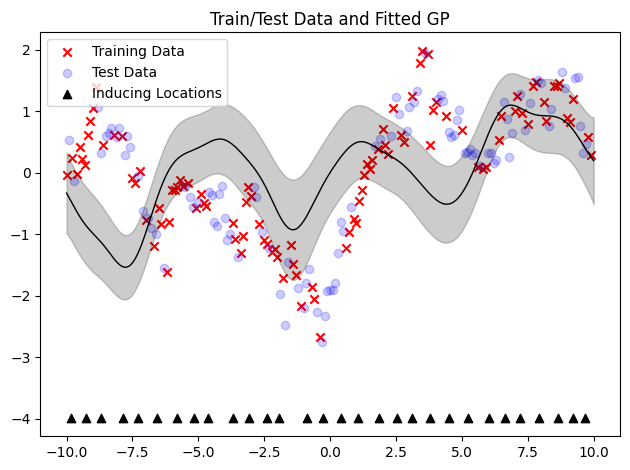

In [22]:
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{w_n_outputs}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=w_C_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=w_my_model.variational_strategy.inducing_points_C.data, n_inducing_C=w_n_inducing_C, picture_save_path=picture_save_path) # NOTE: input is C not X